# Generation of training and testing data from models
****
- Data source: Dr. Michel Curé and Catalina Arcos, IFA UV
- Each model is stored in a file with a name like: "t4000g20v10.dat", where
 - t is the effective temperature: 4000 [K]
 - g is 10 times the logarithm of the gravity in [cm/seg^2]: 20/10 = 2.0
 - v_rot is the rotational velocity in [km/seg]: 10
 
- For this analysis we will consider:
 - v_rot >= 100
 - t_eff >= 15000
 - wavelength range [4460, 4480]

- Note that the y axis is the normalized flux


## Needed libraries

In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shutil

from sklearn.model_selection import train_test_split


## Functions

In [2]:
def string2params(string, show=True):
    s1 = string.partition("g")
    t = s1[0][1:]
    s2 = s1[2].partition("v")
    g = s2[0]
    v = s2[-1]
    if show:
        print(s1)
        print("t:",t)
        print(s2)
        print("g: ",float(g)/10)
        print("v:", v)
    return float(t), float(g)/10, float(v)

## Files list

In [3]:
files = glob.glob('filtered_wv_models/*')
m = len(files)
print("Number of files in models", m)
print("5 first files: \n", files[0:5])


Number of files in models 3875
5 first files: 
 ['filtered_wv_models/f_t17000g30v170.dat', 'filtered_wv_models/f_t19000g45v220.dat', 'filtered_wv_models/f_t30000g45v230.dat', 'filtered_wv_models/f_t38000g45v300.dat', 'filtered_wv_models/f_t20000g30v260.dat']


## Building X an y matrices
*****

In [4]:
print("--> X has dimension", m, " x 201")
print("--> y has diemsnion", m, " x 3")

y = np.zeros((m,3))
df = pd.read_csv(files[0], sep=" ", header=None)
x_points = df[0].values
n_points, n_columns = df.shape
display(df[1].values.shape)
print("Num. of points in x axis: ", n_points)



--> X has dimension 3875  x 201
--> y has diemsnion 3875  x 3


(201,)

Num. of points in x axis:  201


In [7]:
# X matrix contains the spectral lines
X = np.zeros((m,n_points))
# y matrix contains the labels of each spectral line
y = np.zeros((m,3))
for i,name in enumerate(files):
    file_name = name.split("/")[-1].split(".")[0]
    #print(file_name)
    df = pd.read_csv(name, sep=" ", header=None)
    #print(file_name.split("_")[1])
    t,g,v = string2params(file_name.split("_")[1],show=False)
    X[i,:] = df[1].values
    y[i] = t,g,v
    #print("----")

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix


# ¿Será necesario normalizar X?
########
#scaler = StandardScaler()
#scaler.fit(X)
#X_s = scaler.transform(X)

# Normalización de los labels
scaler2 = StandardScaler()
scaler2.fit(y)
y_s = scaler2.transform(y)

## Training, testing and validation sets

In [9]:
def train_val_test_split(X, y, train_size, val_size, test_size, random_state = 1):
    if train_size + val_size + test_size != 1.0:
        print("Incorrect sizes!")
        return None
    
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = val_size/(test_size + train_size), random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y_s, .8, .1, .1)

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3099, 201) (3099, 3)
(388, 201) (388, 3)
(388, 201) (388, 3)


# Convolutional neural network

In [12]:
# about activation functions: https://datascience.stackexchange.com/questions/47751/what-activation-function-should-i-use-for-a-specific-regression-problem

In [13]:
# https://colab.research.google.com/drive/1zjh0tUPYJYgJJunpLC9fW5uf--O0LKeZ?usp=sharing#scrollTo=ud_tq1A0Ffvl

time_steps = X.shape[1]
input_dimension = 1

In [14]:
sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

In [15]:
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)

(3099, 201, 1)
(388, 201, 1)
(388, 201, 1)


# Histograms
*****


In [16]:
def histograms_params(train, test, val, bins, labels, title=None):
    plt.figure()
    plt.hist(train, bins='auto', label=labels[0])
    if val is not None:
        plt.hist(val, bins='auto', label=labels[1])
    if test is not None:
        plt.hist(test, bins='auto', label=labels[2], alpha=0.3)
    
    if title is not None:
        plt.title(title)
    plt.legend(loc="best")
    plt.show()
    

import seaborn as sns
sns.set_theme(style="whitegrid")


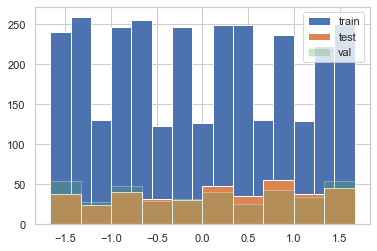

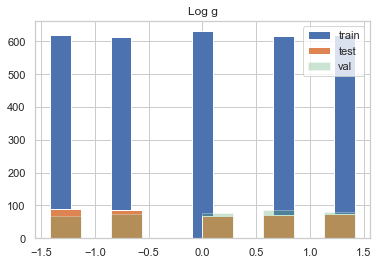

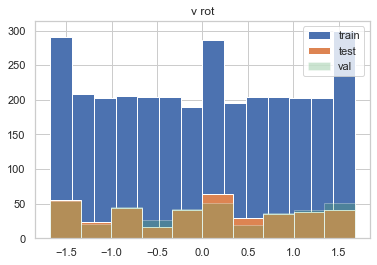

In [17]:
histograms_params(y_train[:,0], y_val[:,0], y_test[:,0], 0, ["train", "test", "val"])
histograms_params(y_train[:,1], y_val[:,1], y_test[:,1], 0, ["train", "test", "val"], "Log g")
histograms_params(y_train[:,2], y_val[:,2], y_test[:,2], 0, ["train", "test", "val"], "v rot")

In [18]:
import tensorflow as tf
import keras

### Optimizar los parámetros de esta red
***
- Puede cambiar la arquitectura, agregando o quitando capas, modificando las funciones de activación, cambiando la función de pérdida, etc.

In [19]:
def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #210
    n_features  = X_train_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', name="Conv1D_1"))
 
    model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2"))
    tf.keras.layers.BatchNormalization()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation= "selu", name="Dense_1"))
    model.add(keras.layers.Dense(3, activation = "linear", name="Dense_4"))


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    l = tf.keras.losses.LogCosh()
    
    
    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

2023-06-22 10:30:35.801938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 195, 32)           256       
                                                                 
 Conv1D_2 (Conv1D)           (None, 193, 16)           1552      
                                                                 
 flatten (Flatten)           (None, 3088)              0         
                                                                 
 Dense_1 (Dense)             (None, 32)                98848     
                                                                 
 Dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 100,755
Trainable params: 100,755
Non-trainable params: 0
_________________________________________________________________


In [20]:
ep = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience=5)
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=ep,
                    validation_data = (X_val_reshaped, y_val), 
                           verbose=1, callbacks=[callback])

Epoch 1/50
97/97 [==============================] - 6s 28ms/step - loss: 1.0580 - mse: 1.0580 - val_loss: 1.0208 - val_mse: 1.0208
Epoch 2/50
97/97 [==============================] - 2s 15ms/step - loss: 0.9165 - mse: 0.9165 - val_loss: 0.8229 - val_mse: 0.8229
Epoch 3/50
97/97 [==============================] - 2s 15ms/step - loss: 0.7265 - mse: 0.7265 - val_loss: 0.6569 - val_mse: 0.6569
Epoch 4/50
97/97 [==============================] - 1s 14ms/step - loss: 0.6136 - mse: 0.6136 - val_loss: 0.5741 - val_mse: 0.5741
Epoch 5/50
97/97 [==============================] - 1s 15ms/step - loss: 0.5750 - mse: 0.5750 - val_loss: 0.5179 - val_mse: 0.5179
Epoch 6/50
97/97 [==============================] - 1s 15ms/step - loss: 0.5300 - mse: 0.5300 - val_loss: 0.5281 - val_mse: 0.5281
Epoch 7/50
97/97 [==============================] - 2s 16ms/step - loss: 0.5145 - mse: 0.5145 - val_loss: 0.5592 - val_mse: 0.5592
Epoch 8/50
97/97 [==============================] - 2s 16ms/step - loss: 0.4985 - m

Testing set Mean Abs Error:  179.00
13/13 [==============================] - 0s 13ms/step


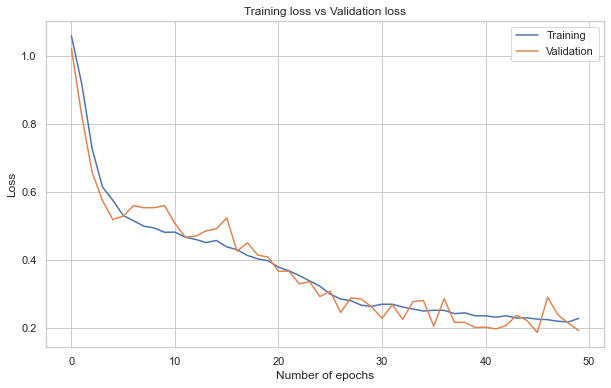

In [21]:
[loss, mae] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

pred =model_conv1D.predict(X_test_reshaped)

y_pred_inv = scaler2.inverse_transform(y)


train_loss = history.history['loss']


val_loss = history.history['val_loss']


def plot_train_val(A, B, n, xlabel, ylabel, title):
    plt.figure(1, figsize=(10, 6))
    plt.plot(range(n),A)
    plt.plot(range(n),B)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(['Training', 'Validation'])
    plt.show()


plot_train_val(train_loss, val_loss, ep, 'Loss', 'Number of epochs', 'Training loss vs Validation loss')

In [22]:
from sklearn.metrics import mean_absolute_error

(388,)
(388,)


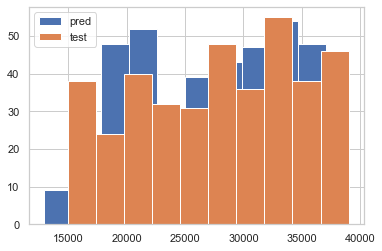

In [23]:
a = scaler2.inverse_transform(pred)
print(a[:,0].shape)


b = scaler2.inverse_transform(y_test)
print(b[:,0].shape)

plt.figure()
plt.hist(a[:,0], label="pred")
plt.hist(b[:,0], label="test")

plt.legend(loc="best")
plt.show()





In [24]:
pred[:,0].shape

(388,)

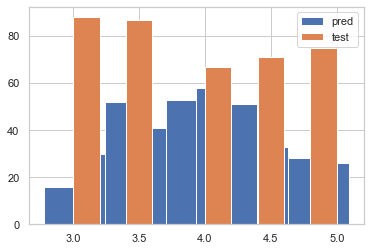

In [25]:
plt.figure()
plt.hist(a[:,1], label="pred")
plt.hist(b[:,1], label="test")

plt.legend(loc="best")
plt.show()



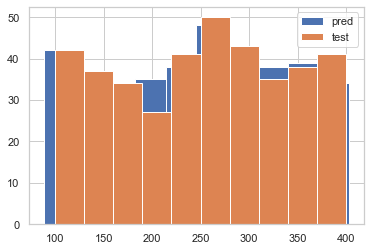

In [26]:

plt.figure()
plt.hist(a[:,2], label="pred")
plt.hist(b[:,2], label="test")

plt.legend(loc="best")
plt.show()



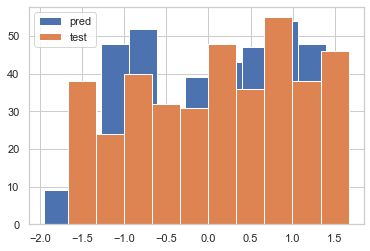

In [27]:
plt.figure()
plt.hist(pred[:,0], label="pred")
plt.hist(y_test[:,0], label="test")

plt.legend(loc="best")
plt.show()


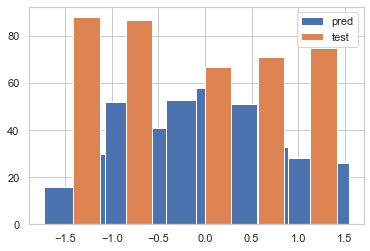

In [28]:
plt.figure()
plt.hist(pred[:,1], label="pred")
plt.hist(y_test[:,1], label="test")

plt.legend(loc="best")
plt.show()

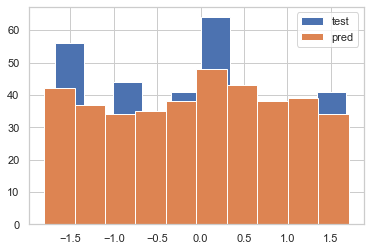

In [29]:
plt.figure()
plt.hist(y_test[:,2], label="test")
plt.hist(pred[:,2], label="pred")
plt.legend(loc="best")
plt.show()

In [30]:
mean_absolute_error(a, b)

797.5560851795566

In [31]:
e_teff = abs(y_test[:,0] - pred[:,0])
e_logg = abs(y_test[:,1] - pred[:,1])
e_vrot = abs(y_test[:,2] - pred[:,2])

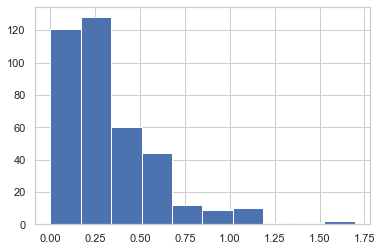

In [32]:
plt.figure()
plt.hist(e_teff)
plt.show()

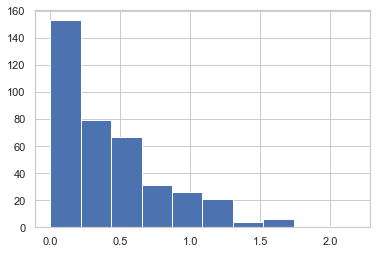

In [33]:
plt.figure()
plt.hist(e_logg)
plt.show()

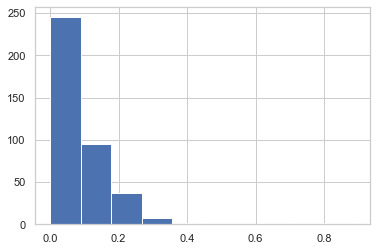

In [34]:
plt.figure()
plt.hist(e_vrot)
plt.show()

# BeSoS lines

In [36]:
df = pd.read_csv("BESOS/2_Be_stars/HD33328/PUCHEROS/hd33328_2013-02-26_00-55-34_final_corr.txt", sep="\t", header=None)

m1 = df[0] >= 4460
m2 = df[0] <= 4480

df2 = df[m1][m2]

df2

/var/folders/9k/d6llwp313m768w9t2bml_6000000gn/T/ipykernel_9292/2473376380.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[m1][m2]


,0,1
2368,4460.008658,1.018850
2369,4460.097998,1.025028
2370,4460.187338,1.014237
2371,4460.276678,1.007267
2372,4460.366019,1.001199
...,...,...
2587,4479.574171,0.981866
2588,4479.663511,0.993424
2589,4479.752851,0.984521
2590,4479.842191,0.957564


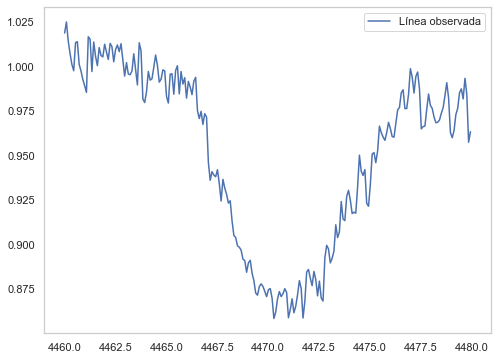

In [37]:
plt.figure(figsize=(8,6))
plt.plot(df2[0], df2[1], label="Línea observada")
#plt.plot(df4[0], df4[1], label="Modelo")
plt.grid()
plt.legend(loc="best")
plt.show()

In [38]:
n = 201  # for 2 random indices
index = np.random.choice(df2[0].shape[0], n, replace=False) 

In [39]:
index.sort()

In [40]:
obs_waves = df2[0].values[index]

obs_flux = df2[1].values[index]



In [41]:
obs_flux.shape

(201,)

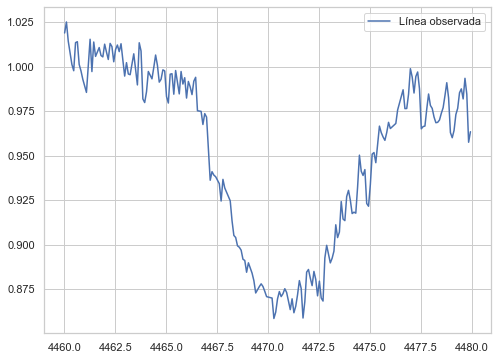

In [42]:
plt.figure(figsize=(8,6))
plt.plot(obs_waves, obs_flux ,label="Línea observada")
plt.legend(loc="best")
plt.show()

In [43]:
#obs_x_reshaped = x_obs_inv.reshape((1, time_steps, input_dimension))
#obs_x_reshaped = obs_x.reshape((1, time_steps, input_dimension))

obs_flux_reshaped = obs_flux.reshape((1, time_steps, input_dimension))

In [44]:
pred_obs =model_conv1D.predict(obs_flux_reshaped)

1/1 [==============================] - 0s 54ms/step


In [45]:
# Acá los resultados es con los datos normalizados
print("t_eff:", pred_obs[0][0])
print("log g:", pred_obs[0][1])
print("v_rot:", pred_obs[0][2])


t_eff: -0.6223042
log g: 0.1526095
v_rot: 0.77248645


## "Desnomralización de la predicción"

In [46]:
pred_obs_inv = scaler2.inverse_transform(pred_obs)

In [47]:
pred_obs_inv

array([[2.251250e+04, 4.107911e+00, 3.190933e+02]], dtype=float32)

In [48]:
print(pred_obs_inv[0,0])
print(pred_obs_inv[0,1])
print(pred_obs_inv[0,2])

22512.5
4.107911
319.0933
